#PREDICTING GAMING ADDICTION

#### 1) DATA CLEANING AND PREPROCESSING

In [2]:
# Import necessary libraries for data manipulation
import pandas as pd
import numpy as np

# Load the dataset into a pandas DataFrame
df = pd.read_csv("/content/online_gaming_behavior_dataset.csv")

# Create a working copy to avoid modifying the original dataset
df_clean = df.copy()


##### DATA CLEANING AND STANDARDIZATION


# Standardize categorical text fields by removing extra spaces
# and ensuring consistent capitalization across all entries
df_clean['Gender'] = df_clean['Gender'].str.strip().str.title()
df_clean['Location'] = df_clean['Location'].str.strip().str.title()
df_clean['GameGenre'] = df_clean['GameGenre'].str.strip().str.title()
df_clean['GameDifficulty'] = df_clean['GameDifficulty'].str.strip().str.title()
df_clean['EngagementLevel'] = df_clean['EngagementLevel'].str.strip().str.title()

# Keep only records with realistic age values (between 10 and 80 years)
df_clean = df_clean[(df_clean['Age'] >= 10) & (df_clean['Age'] <= 80)]

# Remove impossible playtime values
# For example, there are 168 hours in a week, so any player with playtime above that threshold is considered invalid.
df_clean.loc[df_clean['PlayTimeHours'] > 168, 'PlayTimeHours'] = np.nan
df_clean.dropna(subset=['PlayTimeHours'], inplace=True)

# Round playtime hours to the nearest whole number to make visualization and interpretation easier
df_clean['PlayTimeHours'] = df_clean['PlayTimeHours'].round(0).astype(int)


# REDEFINE ENGAGEMENT LEVEL


# Redefine the engagement level categories (Low, Medium, High) based on a combination of playtime hours and session frequency.
# This helps correct inconsistencies in the original dataset.
def relabel_engagement(row):
    if row['PlayTimeHours'] >= 25 or row['SessionsPerWeek'] >= 10:
        return 'High'
    elif 10 <= row['PlayTimeHours'] < 25 or 5 <= row['SessionsPerWeek'] < 10:
        return 'Medium'
    else:
        return 'Low'

df_clean['EngagementLevel'] = df_clean.apply(relabel_engagement, axis=1)


##### STANDARDIZE IN-GAME PURCHASES

# Convert the InGamePurchases column to binary values:
# 1 if the player makes purchases, 0 if not.
# This ensures consistency when used in modeling.
df_clean['InGamePurchases'] = df_clean['InGamePurchases'].apply(lambda x: 1 if x == 1 else 0)


##### PLAYER PROGRESSION VALIDATION

# Clip player levels to be within 1–100 to remove outliers
df_clean['PlayerLevel'] = np.clip(df_clean['PlayerLevel'], 1, 100)

# Ensure achievements are not unrealistically high relative to player level.
# If AchievementsUnlocked > 1.5 × PlayerLevel, cap them to PlayerLevel.
df_clean.loc[df_clean['AchievementsUnlocked'] > df_clean['PlayerLevel'] * 1.5, 'AchievementsUnlocked'] = df_clean['PlayerLevel']


##### SESSION DURATION CLEANUP

# Limit average session duration to a maximum of 300 minutes (5 hours)
# to remove unrealistic extreme values
df_clean.loc[df_clean['AvgSessionDurationMinutes'] > 300, 'AvgSessionDurationMinutes'] = 300


##### REGION MAPPING

# Map country-level 'Location' entries to broader 'Region' categories to simplify geographic analysis
region_map = {
    'Usa': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Uk': 'Europe', 'Germany': 'Europe', 'France': 'Europe',
    'India': 'Asia', 'China': 'Asia', 'Japan': 'Asia', 'Korea': 'Asia',
    'Australia': 'Oceania',
    'Brazil': 'South America', 'Argentina': 'South America',
    'South Africa': 'Africa', 'Nigeria': 'Africa'
}
df_clean['Region'] = df_clean['Location'].map(region_map).fillna('Other')


##### FEATURE ENGINEERING

# Compute total gameplay hours per week by combining session duration and frequency
df_clean['HoursPerSession'] = (df_clean['AvgSessionDurationMinutes'] * df_clean['SessionsPerWeek']) / 60

# Compute spending rate as the ratio of purchases to total playtime (adding +1 to the denominator to avoid division by zero)
df_clean['SpendingRate'] = df_clean['InGamePurchases'] / (df_clean['PlayTimeHours'] + 1)


##### ADDICTION SCORING FUNCTION

# Define a scoring function that estimates addiction risk based on behavioral indicators.
# Each factor contributes points to a base score, which represents the player's likelihood of addiction.
def addiction_score(row):
    base_score = 0

    # Playtime contribution
    if row['PlayTimeHours'] > 40:
        base_score += 3
    elif row['PlayTimeHours'] > 20:
        base_score += 2
    elif row['PlayTimeHours'] > 10:
        base_score += 1

    # Frequency contribution
    if row['SessionsPerWeek'] > 14:
        base_score += 3
    elif row['SessionsPerWeek'] > 7:
        base_score += 2

    # Session duration contribution
    if row['AvgSessionDurationMinutes'] > 180:
        base_score += 2
    elif row['AvgSessionDurationMinutes'] > 120:
        base_score += 1

    # Spending contribution (binary purchases)
    if row['InGamePurchases'] == 1:
        base_score += 2

    # Achievement and player progression contribution
    if row['AchievementsUnlocked'] > 50:
        base_score += 1
    if row['PlayerLevel'] > 80:
        base_score += 1

    # Age adjustment: younger players have a slightly higher sensitivity
    if row['Age'] < 18:
        base_score *= 1.3

    return base_score

# Apply the scoring function to create a new column
df_clean['AddictionScore'] = df_clean.apply(addiction_score, axis=1)


##### TARGET VARIABLE DEFINITION

# Define a binary target variable for modeling:
# 1 = addicted (AddictionScore ≥ 6), 0 = not addicted
df_clean['IsAddicted'] = np.where(df_clean['AddictionScore'] >= 6, 1, 0)


# FINAL CLEANUP

# Drop non-predictive identifier columns
df_clean.drop(columns=['PlayerID'], inplace=True)

# Display confirmation and dataset overview
print("Dataset cleaned successfully. Shape:", df_clean.shape)
print(df_clean.head())


Dataset cleaned successfully. Shape: (40034, 17)
   Age  Gender Location GameGenre  PlayTimeHours  InGamePurchases  \
0   43    Male    Other  Strategy             16                0   
1   29  Female      Usa  Strategy              6                0   
2   22  Female      Usa    Sports              8                0   
3   35    Male      Usa    Action              5                1   
4   33    Male   Europe    Action             16                0   

  GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
0         Medium                6                        108           79   
1         Medium                5                        144           11   
2           Easy               16                        142           35   
3           Easy                9                         85           57   
4         Medium                2                        131           95   

   AchievementsUnlocked EngagementLevel         Region  HoursPerSession  

####2) EXPLORATORY DATA ANALYSIS (EDA)

In [3]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Aesthetic settings
sns.set_theme(style="whitegrid", palette="deep")

#Quick Overview
print("Dataset Shape:", df_clean.shape)
print("\nMissing Values:\n", df_clean.isnull().sum())
print("\nData Types:\n", df_clean.dtypes)
print("\nTarget Distribution (IsAddicted):\n", df_clean['IsAddicted'].value_counts(normalize=True).round(2))

#Descriptive Stats
display(df_clean.describe(include='all').T)


Dataset Shape: (40034, 17)

Missing Values:
 Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
Region                       0
HoursPerSession              0
SpendingRate                 0
AddictionScore               0
IsAddicted                   0
dtype: int64

Data Types:
 Age                            int64
Gender                        object
Location                      object
GameGenre                     object
PlayTimeHours                  int64
InGamePurchases                int64
GameDifficulty                object
SessionsPerWeek                int64
AvgSessionDurationMinutes      int64
PlayerLevel                    int64
AchievementsUnlocked           

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,40034.0,NaN,NaN,NaN,31.992531,10.043227,15.0,23.0,32.0,41.0,49.0
Gender,40034,2,Male,23959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,40034,4,Usa,16000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GameGenre,40034,5,Sports,8048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PlayTimeHours,40034.0,NaN,NaN,NaN,12.02378,6.924924,0.0,6.0,12.0,18.0,24.0
InGamePurchases,40034.0,NaN,NaN,NaN,0.200854,0.400644,0.0,0.0,0.0,0.0,1.0
GameDifficulty,40034,3,Easy,20015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SessionsPerWeek,40034.0,NaN,NaN,NaN,9.471774,5.763667,0.0,4.0,9.0,14.0,19.0
AvgSessionDurationMinutes,40034.0,NaN,NaN,NaN,94.792252,49.011375,10.0,52.0,95.0,137.0,179.0
PlayerLevel,40034.0,NaN,NaN,NaN,49.655568,28.588379,1.0,25.0,49.0,74.0,99.0


  **a) Addiction Status Distribution**

/tmp/ipython-input-1947542700.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='IsAddicted', palette='mako')


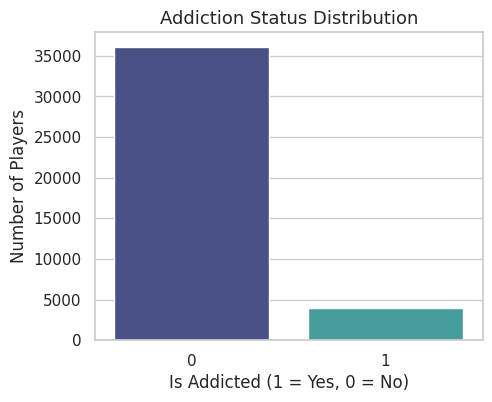

In [4]:
plt.figure(figsize=(5,4))
sns.countplot(data=df_clean, x='IsAddicted', palette='mako')
plt.title("Addiction Status Distribution", fontsize=13)
plt.xlabel("Is Addicted (1 = Yes, 0 = No)")
plt.ylabel("Number of Players")
plt.show()


**b) Age Distribution of Players**

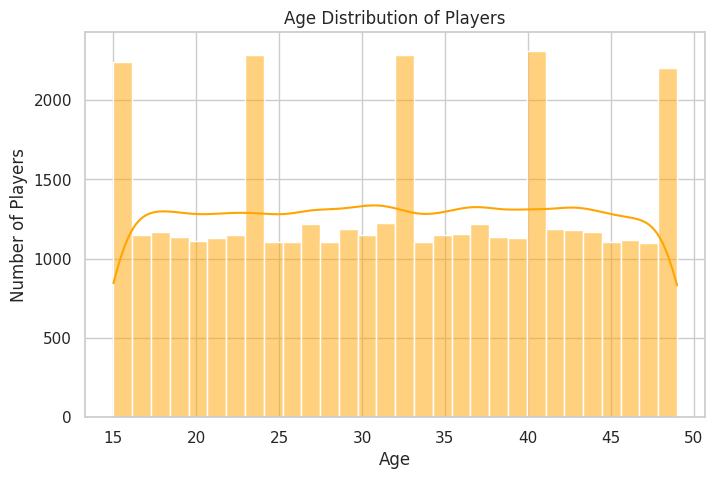

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df_clean['Age'], bins=30, kde=True, color='orange')
plt.title("Age Distribution of Players")
plt.xlabel("Age")
plt.ylabel("Number of Players")
plt.show()


**c) Weekly playtime and Sessions per week distributions**

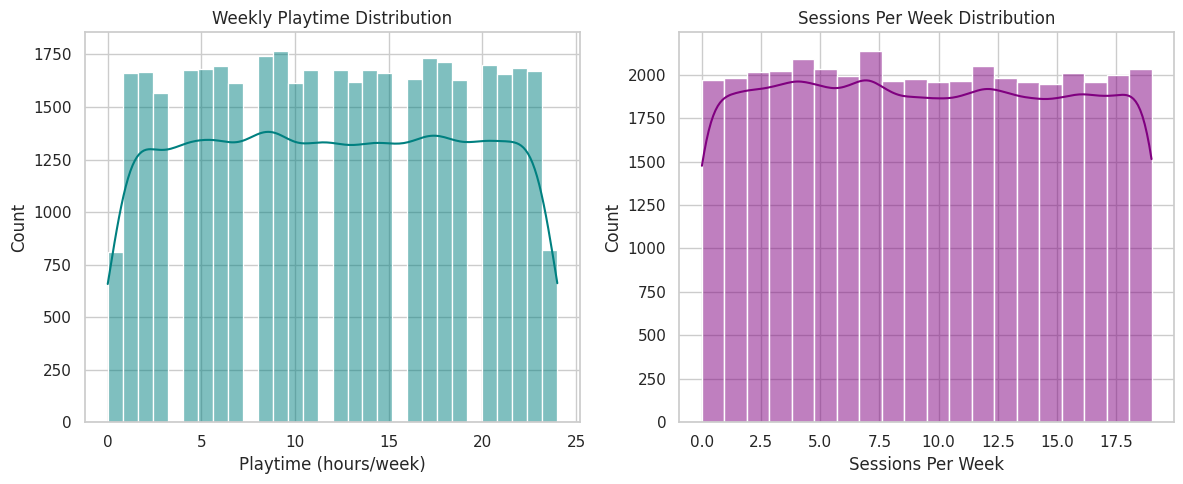

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df_clean['PlayTimeHours'], bins=30, kde=True, ax=axes[0], color='teal')
axes[0].set_title("Weekly Playtime Distribution")
axes[0].set_xlabel("Playtime (hours/week)")

sns.histplot(df_clean['SessionsPerWeek'], bins=20, kde=True, ax=axes[1], color='purple')
axes[1].set_title("Sessions Per Week Distribution")
axes[1].set_xlabel("Sessions Per Week")

plt.tight_layout()
plt.show()


**d) Spending Behaviors of each gamer**

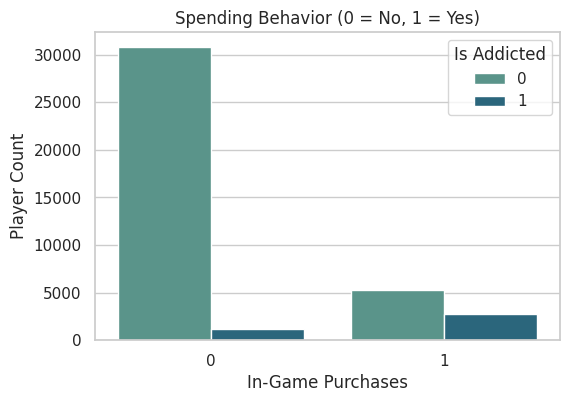

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_clean, x='InGamePurchases', hue='IsAddicted', palette='crest')
plt.title("Spending Behavior (0 = No, 1 = Yes)")
plt.xlabel("In-Game Purchases")
plt.ylabel("Player Count")
plt.legend(title="Is Addicted")
plt.show()


**e) Player Level and Achievements Unlocked Distributions**

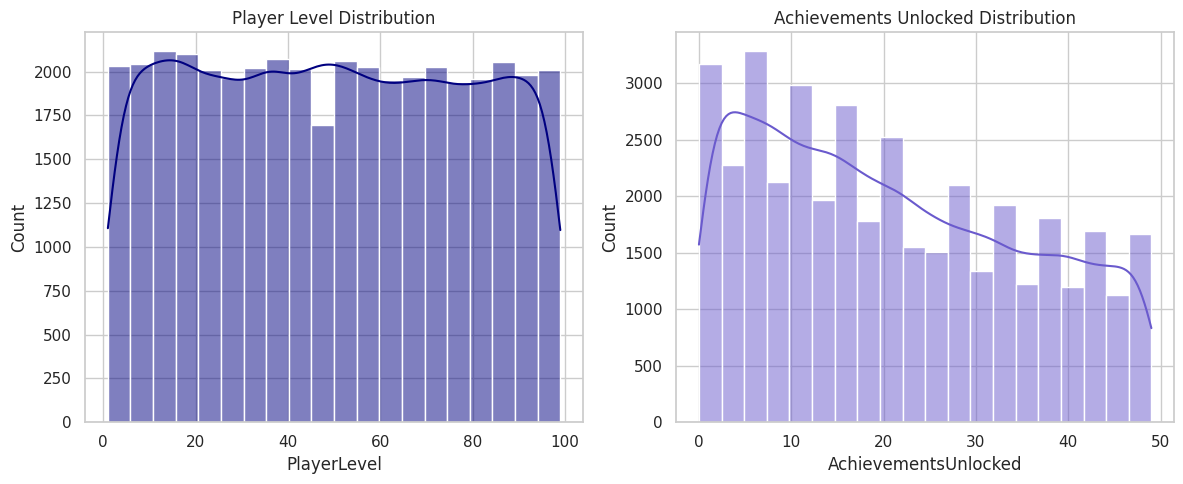

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df_clean['PlayerLevel'], bins=20, kde=True, color='navy', ax=axes[0])
axes[0].set_title("Player Level Distribution")

sns.histplot(df_clean['AchievementsUnlocked'], bins=20, kde=True, color='slateblue', ax=axes[1])
axes[1].set_title("Achievements Unlocked Distribution")

plt.tight_layout()
plt.show()


**f) Addiction Prevalence by Region**

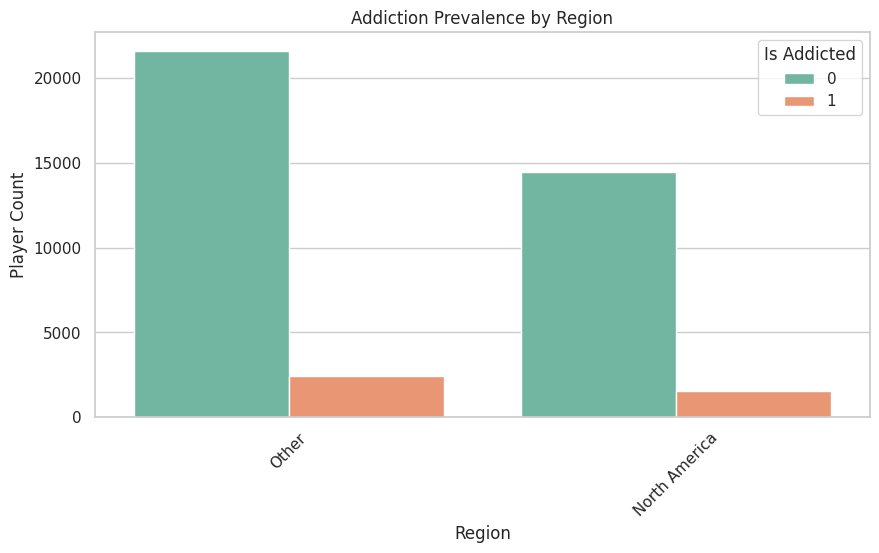

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_clean, x='Region', hue='IsAddicted', palette='Set2')
plt.title("Addiction Prevalence by Region")
plt.xticks(rotation=45)
plt.xlabel("Region")
plt.ylabel("Player Count")
plt.legend(title="Is Addicted")
plt.show()


**g) Game Genre VS Addiction**

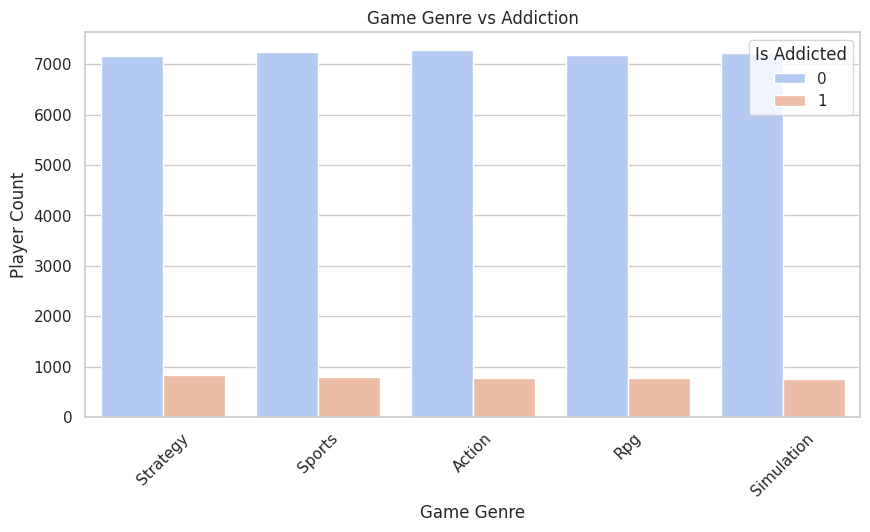

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_clean, x='GameGenre', hue='IsAddicted', palette='coolwarm')
plt.title("Game Genre vs Addiction")
plt.xticks(rotation=45)
plt.xlabel("Game Genre")
plt.ylabel("Player Count")
plt.legend(title="Is Addicted")
plt.show()


**h) Engagement Level VS Addiction**

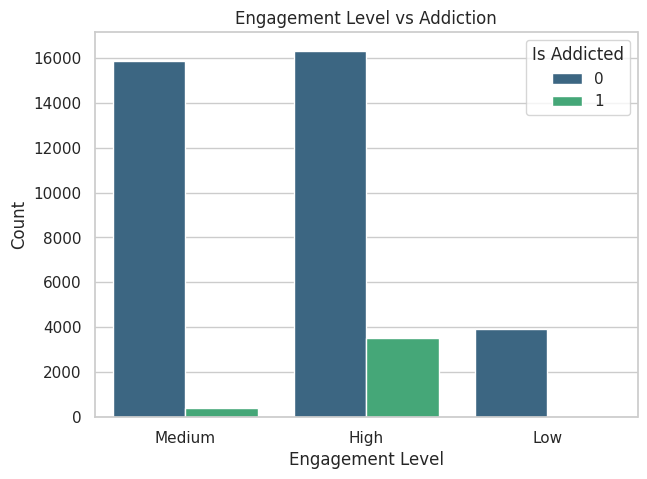

In [11]:
plt.figure(figsize=(7,5))
sns.countplot(data=df_clean, x='EngagementLevel', hue='IsAddicted', palette='viridis')
plt.title("Engagement Level vs Addiction")
plt.xlabel("Engagement Level")
plt.ylabel("Count")
plt.legend(title="Is Addicted")
plt.show()


**i) Correlation Matrix**

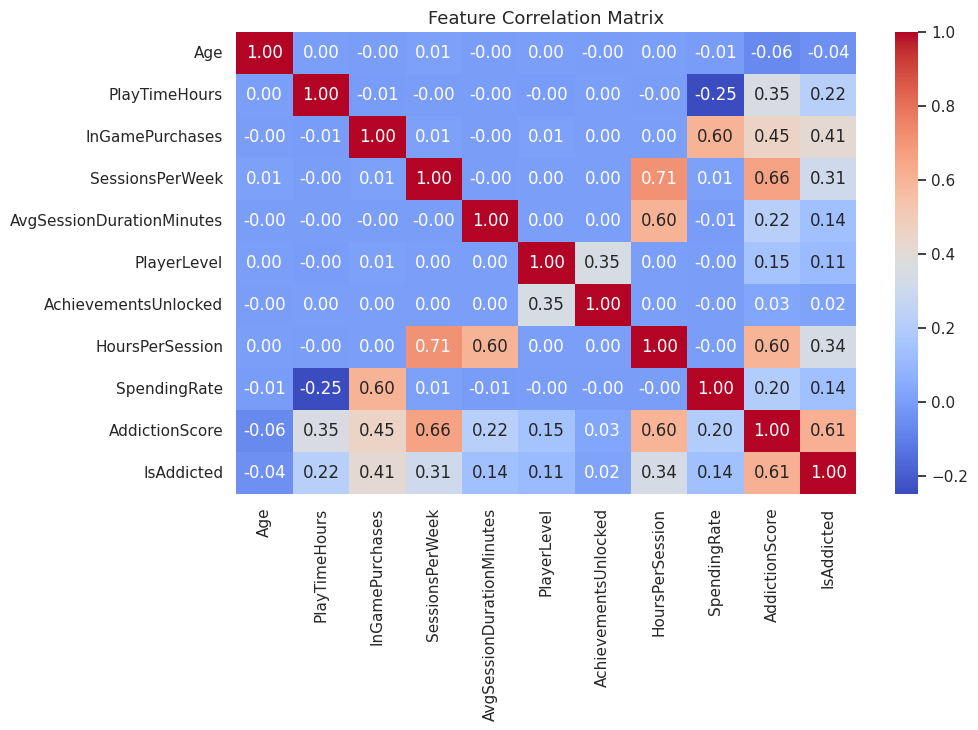

🔎 Correlation with Addiction:
 IsAddicted                   1.000000
AddictionScore               0.610057
InGamePurchases              0.411741
HoursPerSession              0.340663
SessionsPerWeek              0.308523
PlayTimeHours                0.215531
SpendingRate                 0.136405
AvgSessionDurationMinutes    0.135530
PlayerLevel                  0.107750
AchievementsUnlocked         0.018219
Age                         -0.044238
Name: IsAddicted, dtype: float64


In [12]:
plt.figure(figsize=(10,6))
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix", fontsize=13)
plt.show()

# Print strongest correlations with target
corr_target = corr['IsAddicted'].sort_values(ascending=False)
print("🔎 Correlation with Addiction:\n", corr_target)


**j) Comparison Boxplots**

/tmp/ipython-input-834071357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='IsAddicted', y='PlayTimeHours', palette='rocket', ax=axes[0])
/tmp/ipython-input-834071357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='IsAddicted', y='SessionsPerWeek', palette='mako', ax=axes[1])
/tmp/ipython-input-834071357.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='IsAddicted', y='HoursPerSession', palette='crest', ax=axes[2])


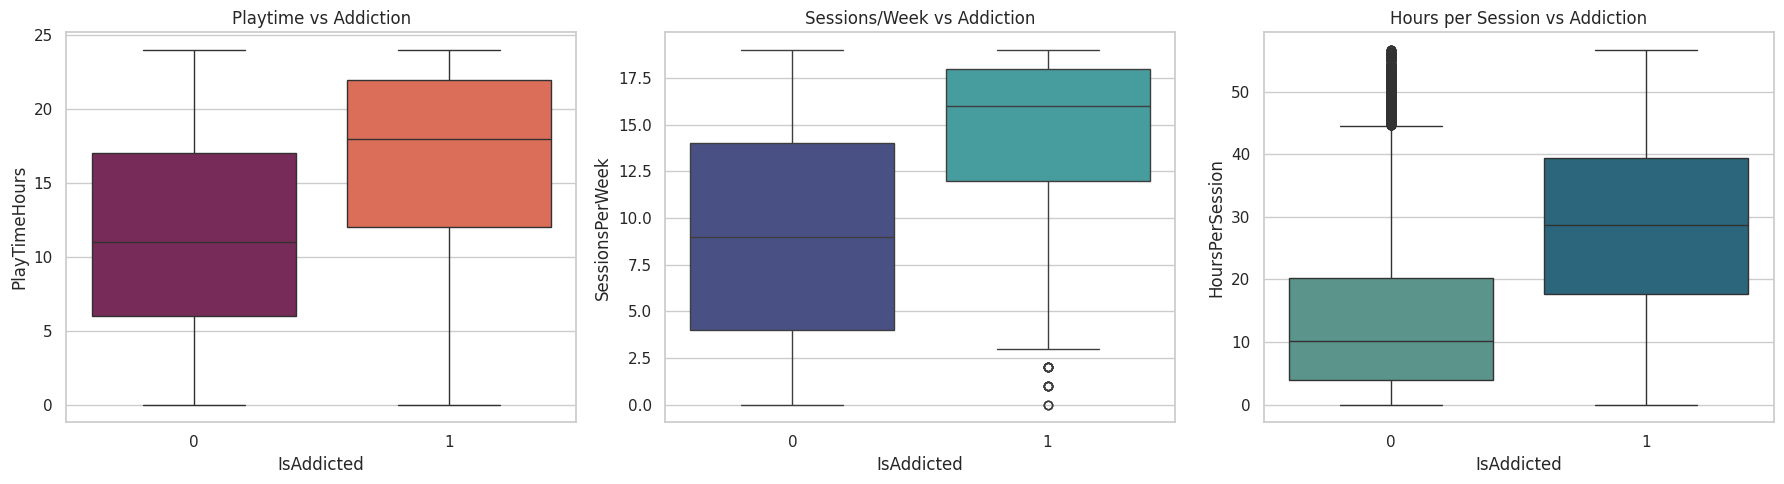

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(data=df_clean, x='IsAddicted', y='PlayTimeHours', palette='rocket', ax=axes[0])
axes[0].set_title("Playtime vs Addiction")

sns.boxplot(data=df_clean, x='IsAddicted', y='SessionsPerWeek', palette='mako', ax=axes[1])
axes[1].set_title("Sessions/Week vs Addiction")

sns.boxplot(data=df_clean, x='IsAddicted', y='HoursPerSession', palette='crest', ax=axes[2])
axes[2].set_title("Hours per Session vs Addiction")

plt.tight_layout()
plt.show()


**k) Age VS Addiction**

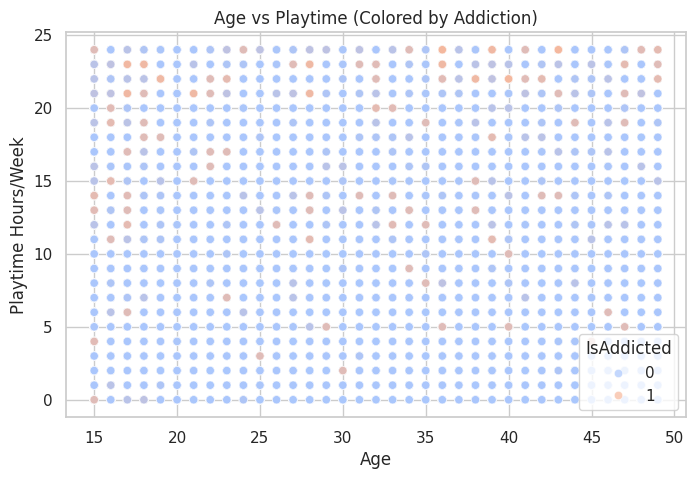

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x='Age', y='PlayTimeHours', hue='IsAddicted', palette='coolwarm', alpha=0.7)
plt.title("Age vs Playtime (Colored by Addiction)")
plt.xlabel("Age")
plt.ylabel("Playtime Hours/Week")
plt.show()


**l) EDA SUMMARY**

In [15]:
print("EDA Summary:")
print(f"- Average playtime: {df_clean['PlayTimeHours'].mean():.1f} hours/week")
print(f"- Average sessions per week: {df_clean['SessionsPerWeek'].mean():.1f}")
print(f"- % Addicted: {df_clean['IsAddicted'].mean() * 100:.1f}%")
print(f"- Highest correlated features: {corr_target.head(5).to_dict()}")


EDA Summary:
- Average playtime: 12.0 hours/week
- Average sessions per week: 9.5
- % Addicted: 9.8%
- Highest correlated features: {'IsAddicted': 1.0, 'AddictionScore': 0.6100568645315706, 'InGamePurchases': 0.41174060855077005, 'HoursPerSession': 0.34066330528162125, 'SessionsPerWeek': 0.30852335746151066}


#### 3) MODEL DEVELOPMENT, TESTING AND EVALUATION

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Logistic Regression Performance:

              precision    recall  f1-score   support

           0      0.967     0.982     0.975     10831
           1      0.811     0.692     0.747      1180

    accuracy                          0.954     12011
   macro avg      0.889     0.837     0.861     12011
weighted avg      0.952     0.954     0.952     12011



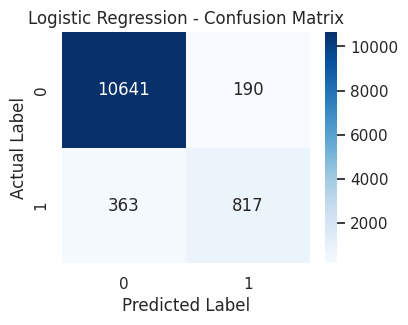

Random Forest Performance:

              precision    recall  f1-score   support

           0      0.995     1.000     0.998     10831
           1      1.000     0.958     0.978      1180

    accuracy                          0.996     12011
   macro avg      0.998     0.979     0.988     12011
weighted avg      0.996     0.996     0.996     12011



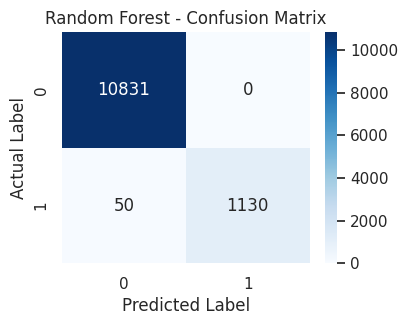

XGBoost Performance:

              precision    recall  f1-score   support

           0      0.999     1.000     1.000     10831
           1      1.000     0.994     0.997      1180

    accuracy                          0.999     12011
   macro avg      1.000     0.997     0.998     12011
weighted avg      0.999     0.999     0.999     12011



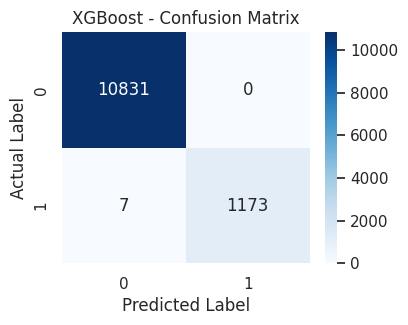



MODEL COMPARISON TABLE


,Accuracy,Precision,Recall,F1-Score
XGBoost,0.999417,1.000000,0.994068,0.997025
Random Forest,0.995837,1.000000,0.957627,0.978355
Logistic Regression,0.953959,0.811321,0.692373,0.747142


In [16]:
# Remove any leftover 'AddictionScore' column to prevent data leakage.
df_clean = df_clean.drop(columns=['AddictionScore'], errors='ignore')

# Import all required libraries for data preprocessing, modeling, and evaluation.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn plotting style for cleaner visuals.
sns.set_theme(style="whitegrid")

# Drop columns that are non-predictive or redundant for model training.
# 'Location' overlaps with 'Region', and 'EngagementLevel' is subjective and inconsistent.
df_clean = df_clean.drop(columns=['Location', 'EngagementLevel'], errors='ignore')

# Encode categorical variables (Gender, Region, GameGenre, GameDifficulty)
# into numeric labels so that machine learning algorithms can process them.
label_cols = ['Gender', 'Region', 'GameGenre', 'GameDifficulty']
encoder = LabelEncoder()
for col in label_cols:
    df_clean[col] = encoder.fit_transform(df_clean[col])

# Separate the dataset into features (X) and target variable (y).
# 'IsAddicted' is the label the model will learn to predict.
X = df_clean.drop(columns=['IsAddicted'])
y = df_clean['IsAddicted']

# Split the dataset into training and testing subsets.
# 70% of data is used for training, 30% for testing.
# Stratified sampling ensures both sets maintain the same class balance.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize numerical features to ensure all variables contribute equally.
# This step centers data around the mean with unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize three machine learning algorithms for comparison:
# 1. Logistic Regression - interpretable linear baseline
# 2. Random Forest - ensemble of decision trees
# 3. XGBoost - gradient boosting model optimized for performance
log_model = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train each model using the training data.
log_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Generate predictions for the test data.
# Logistic Regression uses the scaled features; tree models do not require scaling.
y_pred_log = log_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Combine all models and their predictions into a dictionary for evaluation.
models = {
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

# Evaluate each model using standard classification metrics:
# Accuracy, Precision, Recall, and F1-score.
# Display confusion matrices to visualize prediction errors.
from IPython.display import display

for name, preds in models.items():
    print("="*60)
    print(f"{name} Performance:\n")
    print(classification_report(y_test, preds, digits=3))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# Define a helper function to compute key performance metrics.
def model_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

# Create a summary table comparing all models across core metrics.
results = {name: model_metrics(y_test, preds) for name, preds in models.items()}
results_df = pd.DataFrame(results).T.sort_values(by="F1-Score", ascending=False)

print("\n\nMODEL COMPARISON TABLE")
display(results_df)


***ROC-AUC VISUALIZATION**

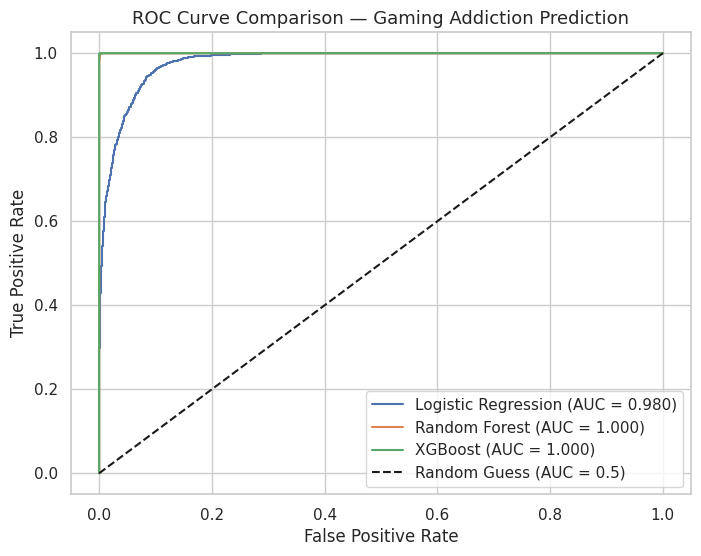

In [17]:

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

plt.figure(figsize=(8,6))

# Logistic Regression
y_pred_log_proba = log_model.predict_proba(X_test_scaled)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log_proba)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")

# Random Forest
y_pred_rf_proba = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")

# XGBoost
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

# --- Plot settings ---
plt.plot([0,1],[0,1],'k--', label='Random Guess (AUC = 0.5)')
plt.title("ROC Curve Comparison — Gaming Addiction Prediction", fontsize=13)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


***FEATURE IMPORTANCE ANALYSIS**

/tmp/ipython-input-4287174773.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='coolwarm')


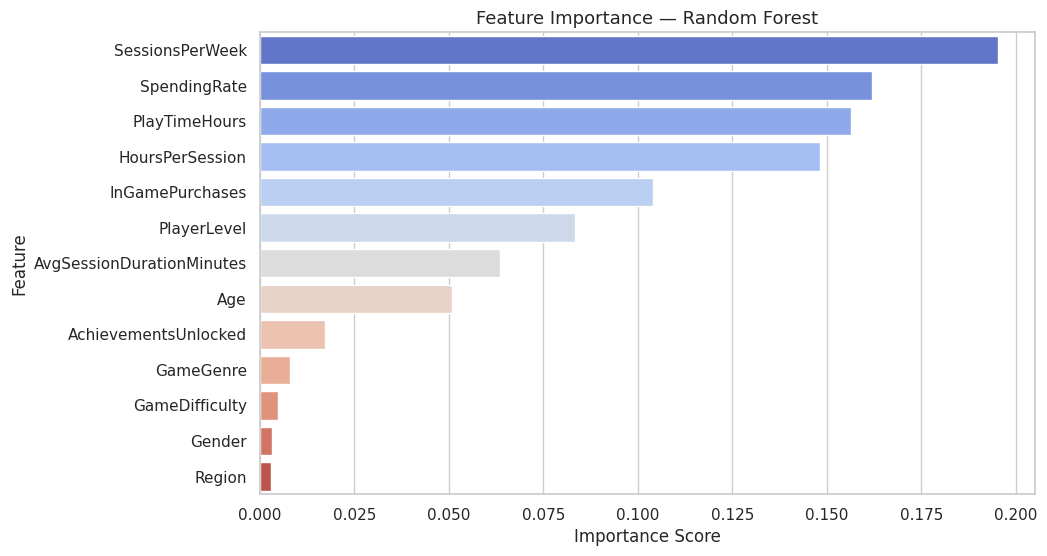

Top Predictors of Gaming Addiction:

SessionsPerWeek              0.195341
SpendingRate                 0.162090
PlayTimeHours                0.156422
HoursPerSession              0.148331
InGamePurchases              0.103979
PlayerLevel                  0.083335
AvgSessionDurationMinutes    0.063630
dtype: float64


In [18]:
# Feature Importance (Random Forest)
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index, palette='coolwarm')
plt.title("Feature Importance — Random Forest", fontsize=13)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Top Predictors
top_features = importances.head(7)
print("Top Predictors of Gaming Addiction:\n")
print(top_features)
